In [154]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy.stats
import seaborn as sns

data = pd.read_csv('../Prepared_Data/data.csv')

In [155]:
##### Set the Plot Sheme #####
import tueplots
from tueplots import bundles

# this provides the color palette of Uni Tuebingen
from tueplots.constants.color import rgb
# e.g. as rgb.tue_blue, rgb.tue_red, etc.

# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=2, usetex=False))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:208: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self._figure.subplots_adjust(right=right)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


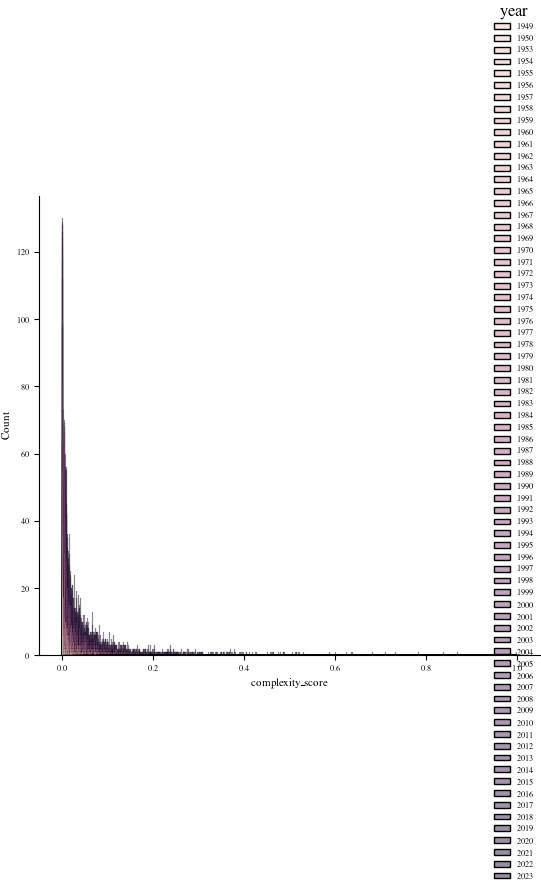

In [138]:
##### Observe data if it is gaussian distibuted #####
sns.displot(data, x ='complexity_score', hue='year')


In [156]:
res = scipy.stats.normaltest(data['complexity_score'])
res.pvalue



0.0

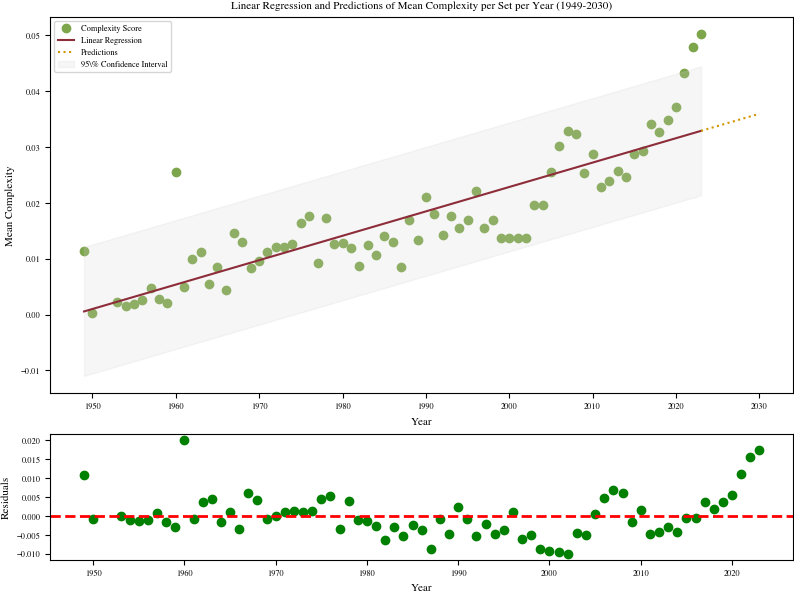

In [157]:
##### Plot mean complexity per set per year and a prediction until 2030#####

def linear_regression_complexity(df):
    
    mean_complexity_per_set_per_year = df.groupby('year')['complexity_score'].mean().reset_index(name='complexity_score')

    # create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})

    x = mean_complexity_per_set_per_year['year'].values.reshape(-1, 1)
    y = mean_complexity_per_set_per_year['complexity_score'].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)

    # plot the original data
    ax1.scatter(x, y, label='Complexity Score', color = rgb.tue_green) 
    ax1.plot(x, y_pred, linestyle='-', label='Linear Regression', color = rgb.tue_red)
    
    # make predictions until 2030
    x_future = np.arange(2023, 2031).reshape(-1, 1)
    y_future_pred = model.predict(x_future)
    ax1.plot(x_future, y_future_pred, linestyle=':', color=rgb.tue_orange, label='Predictions')
    
    # calculate the standard error of the estimate
    residuals = y - y_pred
    mse = np.sum(residuals**2)
    n = len(x)
    k = 2  # number of parameters in the model
    se = np.sqrt(mse / (n - k))

    # plot standard error
    #ax1.fill_between(x.flatten(), y_pred - se, y_pred + se, color='lightgrey', alpha=0.5, label='Standard Error')

    # calculate the confidence intervals
    t = scipy.stats.t.ppf(0.975, df=n-k)  # two-sided 95% confidence interval t-value
    lower_bound = y_pred - t * se
    upper_bound = y_pred + t * se

    # plot the confidence intervals
    ax1.fill_between(x.flatten(), lower_bound, upper_bound, color='lightgray', alpha=0.2, label='95\% Confidence Interval')

    # plot residuals
    ax2.scatter(x, residuals, color='green')
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Residuals')

    # add title and labels
    ax1.set_title('Linear Regression and Predictions of Mean Complexity per Set per Year (1949-2030)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Mean Complexity')
    ax1.legend()

    # save plot
    plt.savefig('../Images/Linear_Regression.pdf')
    
    # show the plot
    plt.show()

# call the function
linear_regression_complexity(data)


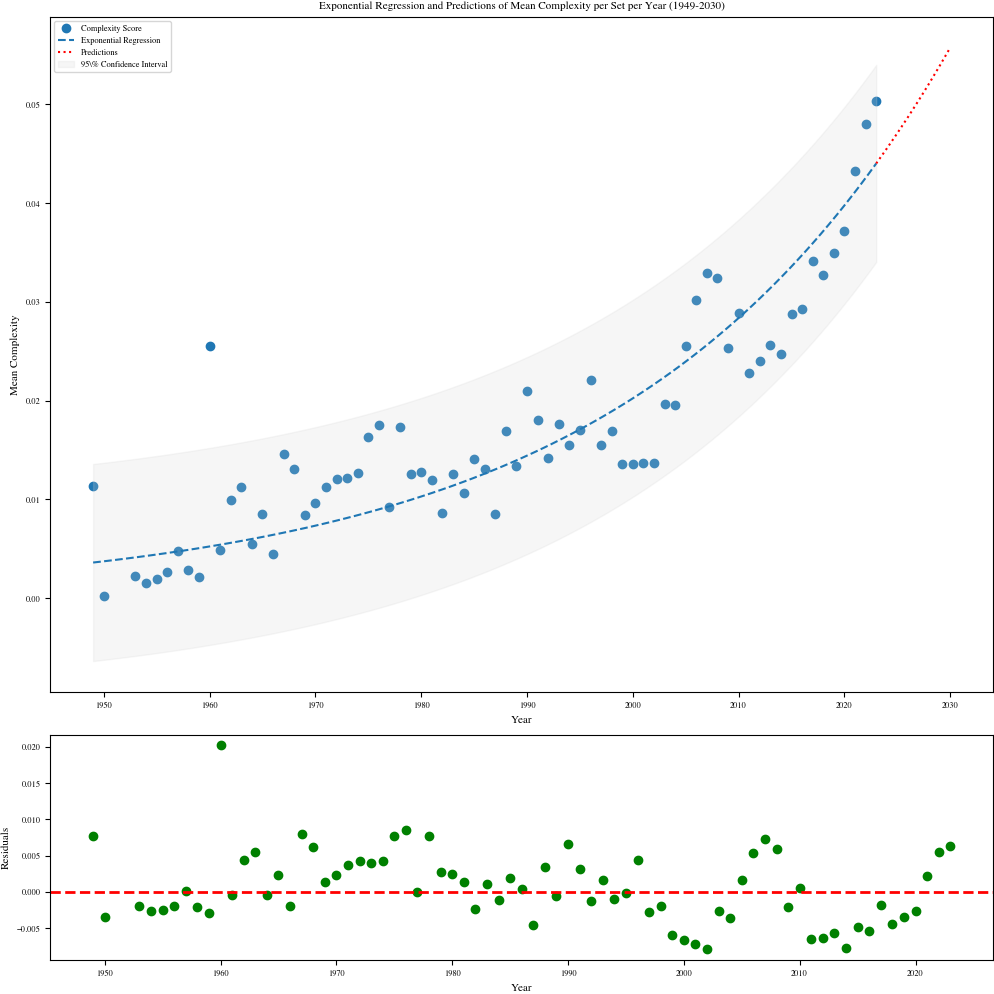

In [158]:
##### Make an exponential Regression #####

def exponential_regression_complexity(df):
    
    mean_complexity_per_set_per_year = df.groupby('year')['complexity_score'].mean().reset_index(name='complexity_score')

    # create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

    x = mean_complexity_per_set_per_year['year'].values
    y = mean_complexity_per_set_per_year['complexity_score'].values

    # perform exponential regression using np.polyfit on the logarithm of the data
    log_y = np.log(y)
    coefficients = np.polyfit(x, log_y, 1)
    a, b = coefficients

    # plot the original data
    ax1.scatter(x, y, label='Complexity Score')

    # plot the fitted exponential curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_pred = np.exp(a * x_fit + b)
    ax1.plot(x_fit, y_pred, linestyle='--', label='Exponential Regression')

    # make predictions until 2030
    x_future = np.arange(2023, 2031)
    y_future_pred = np.exp(a * x_future + b)
    ax1.plot(x_future, y_future_pred, linestyle=':', color='red', label='Predictions')

    # Calculate standard errors of the coefficients
    residuals = y - np.exp(a * x + b)
    mse = np.sum(residuals**2)
    n = len(x)
    k = 2  # number of parameters in the model
    se = np.sqrt(mse / (n - k))

    # plot standard error
    #ax1.fill_between(x_fit.flatten(), y_pred - se, y_pred + se, color='lightgrey', alpha=0.5, label='Standard Error')

    # calculate the confidence intervals
    t = scipy.stats.t.ppf(0.975, df=n-k)  # two-sided 95% confidence interval t-value
    lower_bound = y_pred - t * se
    upper_bound = y_pred + t * se

    # plot the confidence intervals
    ax1.fill_between(x_fit.flatten(), lower_bound, upper_bound, color='lightgray', alpha=0.2, label='95\% Confidence Interval')

    # add title and labels
    ax1.set_title('Exponential Regression and Predictions of Mean Complexity per Set per Year (1949-2030)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Mean Complexity')
    ax1.legend()

    # plot residuals
    residuals = y - np.exp(a * x + b)
    ax2.scatter(x, residuals, color='green')
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Residuals')

    # save plot
    plt.savefig('../Images/Exponential_Regression.pdf')

    # show the plot
    plt.show()

# call the function
exponential_regression_complexity(data)


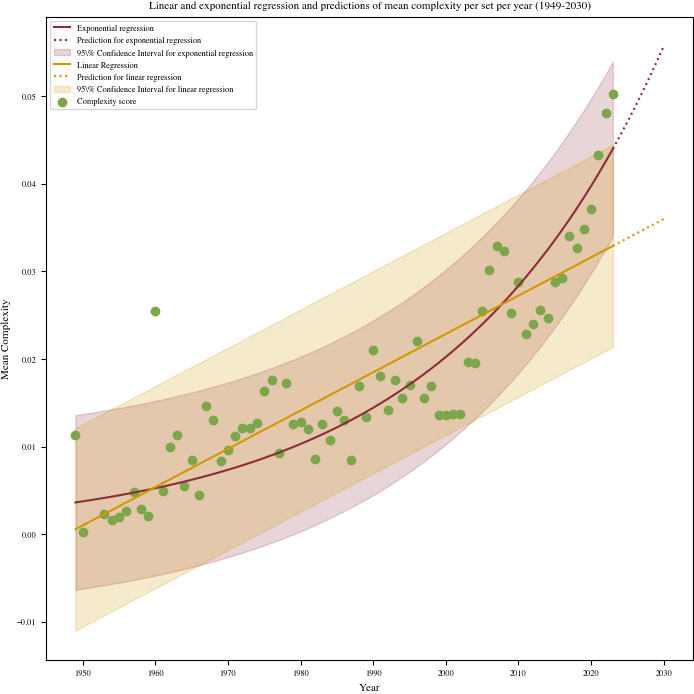

In [159]:
##### Plot both regressions #####

def regression_complexity(df):
    
    mean_complexity_per_set_per_year = df.groupby('year')['complexity_score'].mean().reset_index(name='complexity_score')

    # create the plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    x = mean_complexity_per_set_per_year['year'].values.reshape(-1, 1)
    y = mean_complexity_per_set_per_year['complexity_score'].values

    # perform exponential regression using np.polyfit on the logarithm of the data
    log_y = np.log(y)
    coefficients_exp = np.polyfit(x.flatten(), log_y, 1)
    a_exp, b_exp = coefficients_exp
    y_pred_exp = np.exp(a_exp * x.flatten() + b_exp)

    # plot the fitted exponential curve
    ax.plot(x, y_pred_exp, linestyle='-', label='Exponential regression', color = rgb.tue_red)

    # make predictions until 2030
    x_future_exp = np.arange(2023, 2031)
    y_future_pred_exp = np.exp(a_exp * x_future_exp + b_exp)
    ax.plot(x_future_exp, y_future_pred_exp, linestyle=':', color=rgb.tue_red, label='Prediction for exponential regression')

    # Calculate standard errors of the coefficients
    residuals_exp = y - np.exp(a_exp * x.flatten() + b_exp)
    mse_exp = np.sum(residuals_exp**2)
    n = len(x)
    k = 2  # number of parameters in the model
    se_exp = np.sqrt(mse_exp / (n - k))

    # plot standard error
    #ax1.fill_between(x_fit.flatten(), y_pred - se, y_pred + se, color='lightgrey', alpha=0.5, label='Standard Error')

    # calculate the confidence intervals
    t_exp = scipy.stats.t.ppf(0.975, df=n-k)  # two-sided 95% confidence interval t-value
    lower_bound_exp = y_pred_exp - t_exp * se_exp
    upper_bound_exp = y_pred_exp + t_exp * se_exp

    # plot the confidence intervals
    ax.fill_between(x.flatten(), lower_bound_exp, upper_bound_exp, color=rgb.tue_red, alpha=0.2, label='95\% Confidence Interval for exponential regression')

    # make linear regression
    model_linear = LinearRegression().fit(x, y)
    y_pred_linear = model_linear.predict(x)

    # plot linear regression
    ax.plot(x, y_pred_linear, linestyle='-', label='Linear Regression', color = rgb.tue_orange)
    
    # make predictions until 2030
    x_future_linear = np.arange(2023, 2031).reshape(-1, 1)
    y_future_pred_linear = model_linear.predict(x_future_linear)
    ax.plot(x_future_linear, y_future_pred_linear, linestyle=':', color=rgb.tue_orange, label='Prediction for linear regression')

    # calculate the standard error of the estimate
    residuals_linear = y - y_pred_linear
    mse_linear = np.sum(residuals_linear**2)
    n = len(x)
    k = 2  # number of parameters in the model
    se_linear = np.sqrt(mse_linear / (n - k))

    # plot standard error
    #ax1.fill_between(x.flatten(), y_pred - se, y_pred + se, color='lightgrey', alpha=0.5, label='Standard Error')

    # calculate the confidence intervals
    t_linear = scipy.stats.t.ppf(0.975, df=n-k)  # two-sided 95% confidence interval t-value
    lower_bound_linear = y_pred_linear - t_linear * se_linear
    upper_bound_linear = y_pred_linear + t_linear * se_linear

    # plot the confidence intervals
    ax.fill_between(x.flatten(), lower_bound_linear, upper_bound_linear, color=rgb.tue_orange, alpha=0.2, label='95\% Confidence Interval for linear regression')

    # plot the original data
    ax.scatter(x, y, label='Complexity score', color = rgb.tue_green)

    # add title and labels
    ax.set_title('Linear and exponential regression and predictions of mean complexity per set per year (1949-2030)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean Complexity')
    ax.legend()

    # save plot
    plt.savefig('../Images/Regressions.pdf')

    plt.show()

# call the function
regression_complexity(data)


SSR Linear Regression: 0.0023798725463863185, SSR Exponential Regression: 0.001774351114010668
R^2 Linear Regression: 0.7243557514975683, R^2 Exponential Regression: 0.7944891291999759


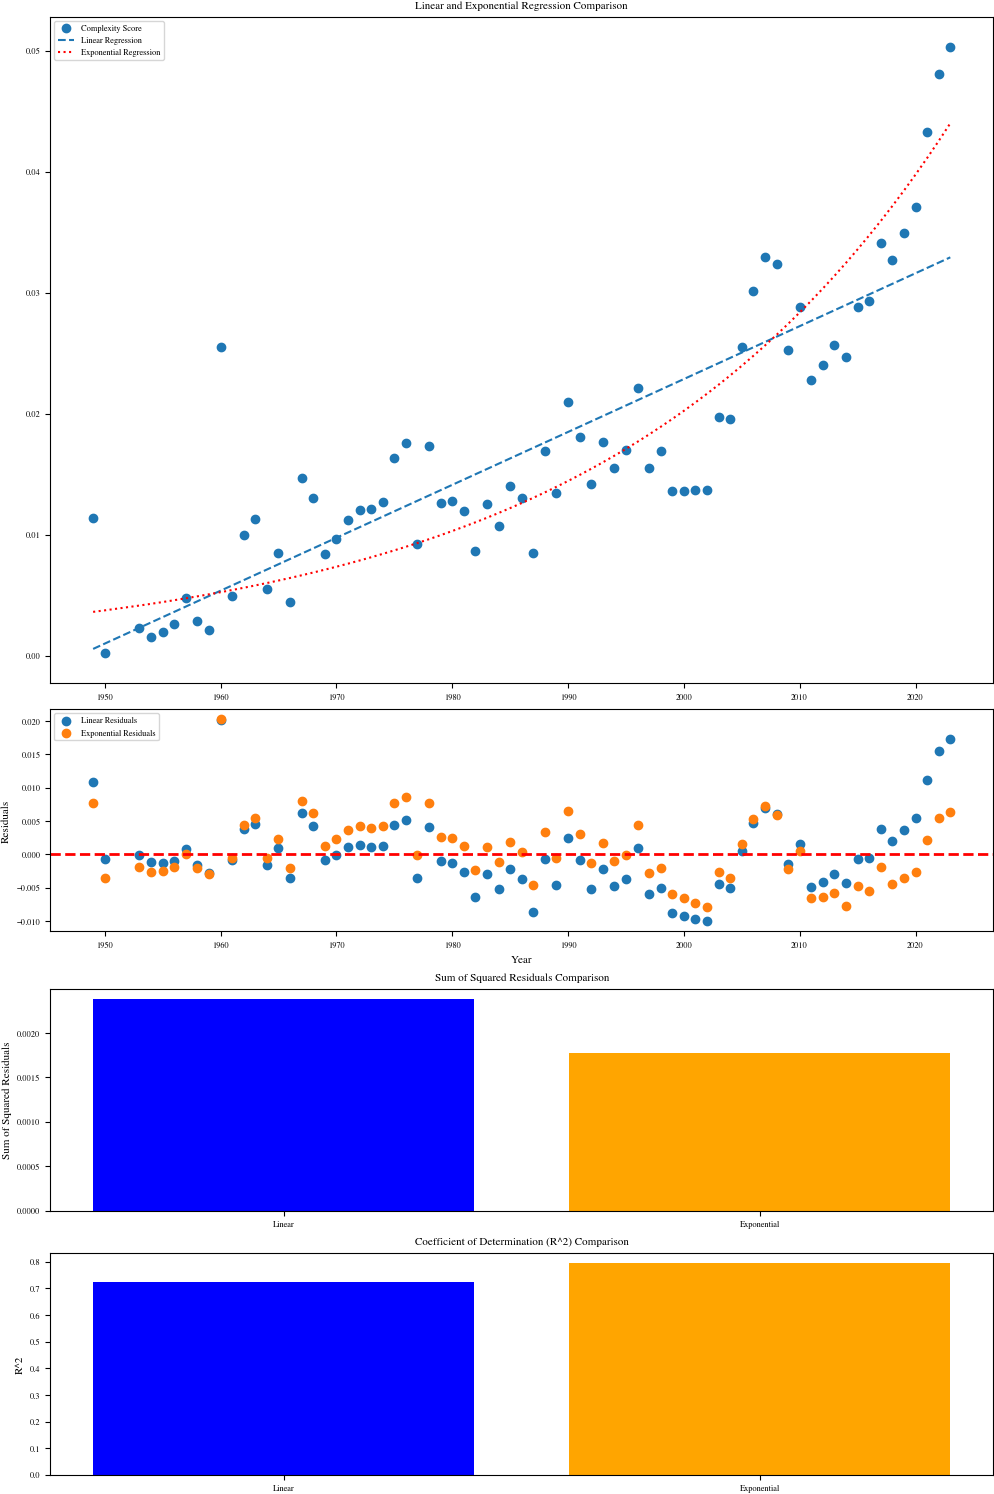

In [160]:
##### Compare the regressions #####

def compare_regression_complexity(df):
    
    mean_complexity_per_set_per_year = df.groupby('year')['complexity_score'].mean().reset_index(name='complexity_score')

    # create the plot
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 15), gridspec_kw={'height_ratios': [3, 1, 1, 1]})

    x = mean_complexity_per_set_per_year['year'].values.reshape(-1, 1)
    y = mean_complexity_per_set_per_year['complexity_score'].values

    # linear Regression
    model_linear = LinearRegression().fit(x, y)
    y_pred_linear = model_linear.predict(x)

    # exponential Regression
    log_y = np.log(y)
    coefficients_exp = np.polyfit(x.flatten(), log_y, 1)
    a_exp, b_exp = coefficients_exp
    y_pred_exp = np.exp(a_exp * x.flatten() + b_exp)

    # residuals
    residuals_linear = y - y_pred_linear
    residuals_exp = y - y_pred_exp

    # plot the original data
    ax1.scatter(x, y, label='Complexity Score')

    # plot Linear Regression
    ax1.plot(x, y_pred_linear, linestyle='--', label='Linear Regression')
    ax1.set_title('Linear and Exponential Regression Comparison')

    # plot Exponential Regression
    ax1.plot(x, y_pred_exp, linestyle=':', color='red', label='Exponential Regression')
    ax1.legend()

    # residual Plots
    ax2.scatter(x, residuals_linear, label='Linear Residuals')
    ax2.scatter(x, residuals_exp, label='Exponential Residuals')
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Residuals')
    ax2.legend()

    # Sum of Squared Residuals
    sum_squared_residuals_linear = np.sum(residuals_linear ** 2)
    sum_squared_residuals_exp = np.sum(residuals_exp ** 2)

    # Coefficient of Determination (R^2)
    r2_linear = model_linear.score(x, y)
    r2_exp = 1 - (np.sum(residuals_exp ** 2) / np.sum((y - np.mean(y)) ** 2))

    # Display results
    ax3.bar(['Linear', 'Exponential'], [sum_squared_residuals_linear, sum_squared_residuals_exp], color=['blue', 'orange'])
    ax3.set_title('Sum of Squared Residuals Comparison')
    ax3.set_ylabel('Sum of Squared Residuals')

    ax4.bar(['Linear', 'Exponential'], [r2_linear, r2_exp], color=['blue', 'orange'])
    ax4.set_title('Coefficient of Determination (R^2) Comparison')
    ax4.set_ylabel('R^2')

    # print information
    print(f'SSR Linear Regression: {sum_squared_residuals_linear}, SSR Exponential Regression: {sum_squared_residuals_exp}')
    print(f'R^2 Linear Regression: {r2_linear}, R^2 Exponential Regression: {r2_exp}')

    # save plot
    plt.savefig('../Images/Regression_Comparison.pdf')

    plt.show()

# call the function
compare_regression_complexity(data)


* R^2 (provides a measure of how well the model explains the variance in the dependent variable, higher R^2 indicates a better fit) --> should be high
* Sum of Squared (Lower sum of squared residuals is usually preferable, as it indicates a better fit to the data) --> should be low 
+ --> exponential regression is better